In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage
from ISLP.cluster import compute_linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.preprocessing import PowerTransformer


In [2]:
# Create plots folder if it doesn't exist
if not os.path.exists('plots'):
    os.makedirs('plots')
    print("Created 'plots' directory")
else:
    print("'plots' directory already exists")


Created 'plots' directory


# EDA

In [3]:
# Load dataset
df = pd.read_csv("IMDB-Movies.csv")

# Display first few rows
print(df.head())

   Unnamed: 0            Title                    Genre  \
0           1  The Dark Knight       Action,Crime,Drama   
1           2        Inception  Action,Adventure,Sci-Fi   
2           3           Dangal   Action,Biography,Drama   
3           4     Interstellar   Adventure,Drama,Sci-Fi   
4           5    Kimi no na wa  Animation,Drama,Fantasy   

                                         Description           Director  \
0  When the menace known as the Joker wreaks havo...  Christopher Nolan   
1  A thief, who steals corporate secrets through ...  Christopher Nolan   
2  Former wrestler Mahavir Singh Phogat and his t...      Nitesh Tiwari   
3  A team of explorers travel through a wormhole ...  Christopher Nolan   
4  Two strangers find themselves linked in a biza...     Makoto Shinkai   

                                              Actors  Year  Runtime..Minutes.  \
0  Christian Bale, Heath Ledger, Aaron Eckhart,Mi...  2008                152   
1  Leonardo DiCaprio, Joseph Gor

In [4]:
# Get info on data types and missing values
print(df.info())

# Check for missing values
print(df.isnull().sum())

# Summary statistics
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          50 non-null     int64  
 1   Title               50 non-null     object 
 2   Genre               50 non-null     object 
 3   Description         50 non-null     object 
 4   Director            50 non-null     object 
 5   Actors              50 non-null     object 
 6   Year                50 non-null     int64  
 7   Runtime..Minutes.   50 non-null     int64  
 8   Rating              50 non-null     float64
 9   Votes               50 non-null     int64  
 10  Revenue..Millions.  47 non-null     float64
dtypes: float64(2), int64(4), object(5)
memory usage: 4.4+ KB
None
Unnamed: 0            0
Title                 0
Genre                 0
Description           0
Director              0
Actors                0
Year                  0
Runtime..Minutes.     0
R

In [5]:
# List all columns
print(df.columns)

# Quick separation of numerical vs categorical columns
numerical_cols = df.select_dtypes(include='number').columns.tolist()
categorical_cols = df.select_dtypes(exclude='number').columns.tolist()

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)


Index(['Unnamed: 0', 'Title', 'Genre', 'Description', 'Director', 'Actors',
       'Year', 'Runtime..Minutes.', 'Rating', 'Votes', 'Revenue..Millions.'],
      dtype='object')
Numerical columns: ['Unnamed: 0', 'Year', 'Runtime..Minutes.', 'Rating', 'Votes', 'Revenue..Millions.']
Categorical columns: ['Title', 'Genre', 'Description', 'Director', 'Actors']


In [6]:
# Drop unnecessary columns
df_clean = df.drop(columns=['Unnamed: 0', 'Title', 'Genre', 'Description', 'Director', 'Actors', 'Year'])

# Drop rows with missing numerical values (only 3 rows affected)
df_clean = df_clean.dropna().reset_index(drop=True)

# Confirm final shape
print("Cleaned dataset shape:", df_clean.shape)
print(df_clean.head())


Cleaned dataset shape: (47, 4)
   Runtime..Minutes.  Rating    Votes  Revenue..Millions.
0                152     9.0  1791916              533.32
1                148     8.8  1583625              292.57
2                161     8.8    48969               11.15
3                169     8.6  1047747              187.99
4                106     8.6    34110                4.68


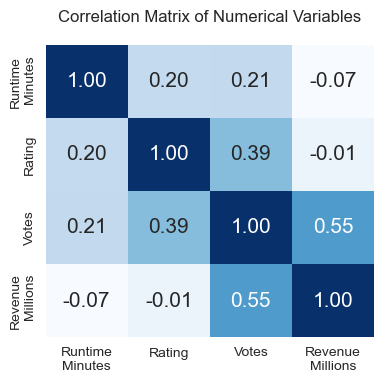

In [7]:
# Compute correlation matrix
corr = df_clean.corr()

# Plot heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(corr.rename(index={'Runtime..Minutes.': 'Runtime\nMinutes', 'Revenue..Millions.': 'Revenue\nMillions'}, 
                              columns={'Runtime..Minutes.': 'Runtime\nMinutes', 'Revenue..Millions.': 'Revenue\nMillions'}),
             annot=True, cmap='Blues', fmt=".2f", annot_kws={"fontsize":15}, cbar=False)
plt.title('Correlation Matrix of Numerical Variables', y=1.05)
plt.tight_layout()
plt.savefig('plots/correlation_matrix.png',dpi = 300)
plt.show()


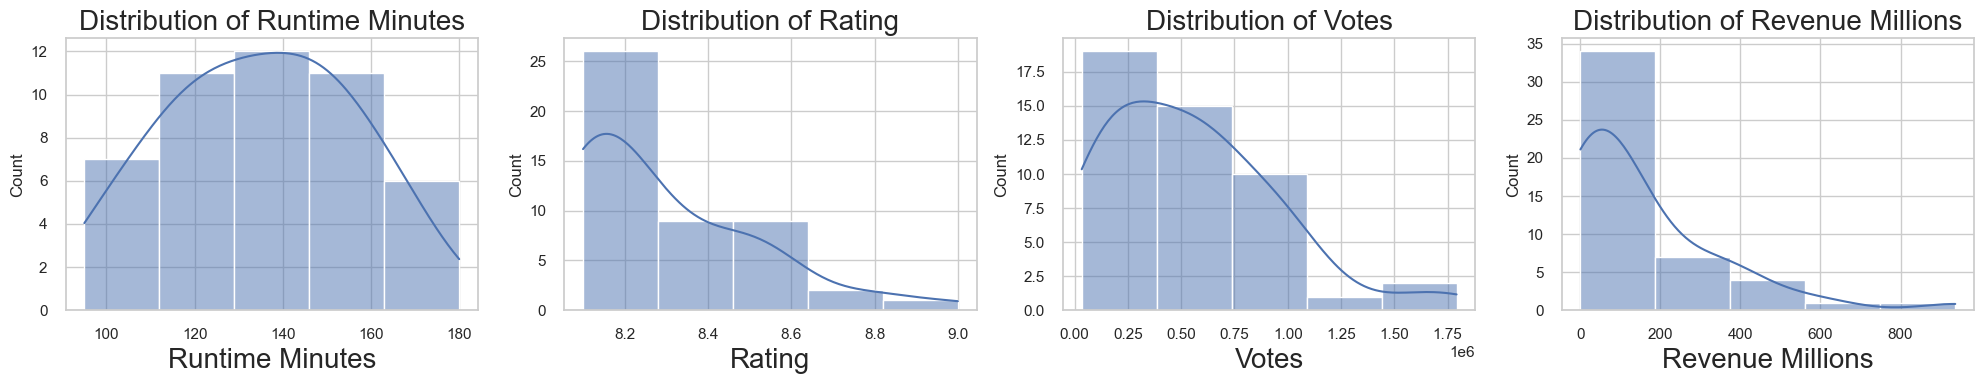

In [8]:
# Set plot style
sns.set(style='whitegrid')

# Select numeric features
num_cols = ['Runtime..Minutes.', 'Rating', 'Votes', 'Revenue..Millions.']

# Plot histograms
plt.figure(figsize=(20, 4))

for i, col in enumerate(num_cols):
    plt.subplot(1, 4, i+1)
    sns.histplot(df_clean[col], kde=True, bins=5)
    plt.title(f'Distribution of {col.replace("..", " ").replace(".", "")}', fontsize=20)
    plt.xlabel(col.replace("..", " ").replace(".", ""), fontsize=20)
    plt.ylabel('Count')
    plt.ylabel('Count')

plt.tight_layout()
plt.savefig('plots/original_histograms.png', dpi=300)
plt.show()


# Preprocessing

In [9]:
# Copy the clean data
df_transformed = df_clean.copy()

pt = PowerTransformer(method='yeo-johnson')

# Apply log1p (log(1 + x)) to avoid log(0) issues
df_transformed['Votes'] = np.log1p(df_transformed['Votes'])
df_transformed['Revenue..Millions.'] = np.log1p(df_transformed['Revenue..Millions.'])
# Apply Yeo-Johnson transformation to Rating, for smoother distribution
df_transformed['Rating'] = pt.fit_transform(df_transformed[['Rating']])


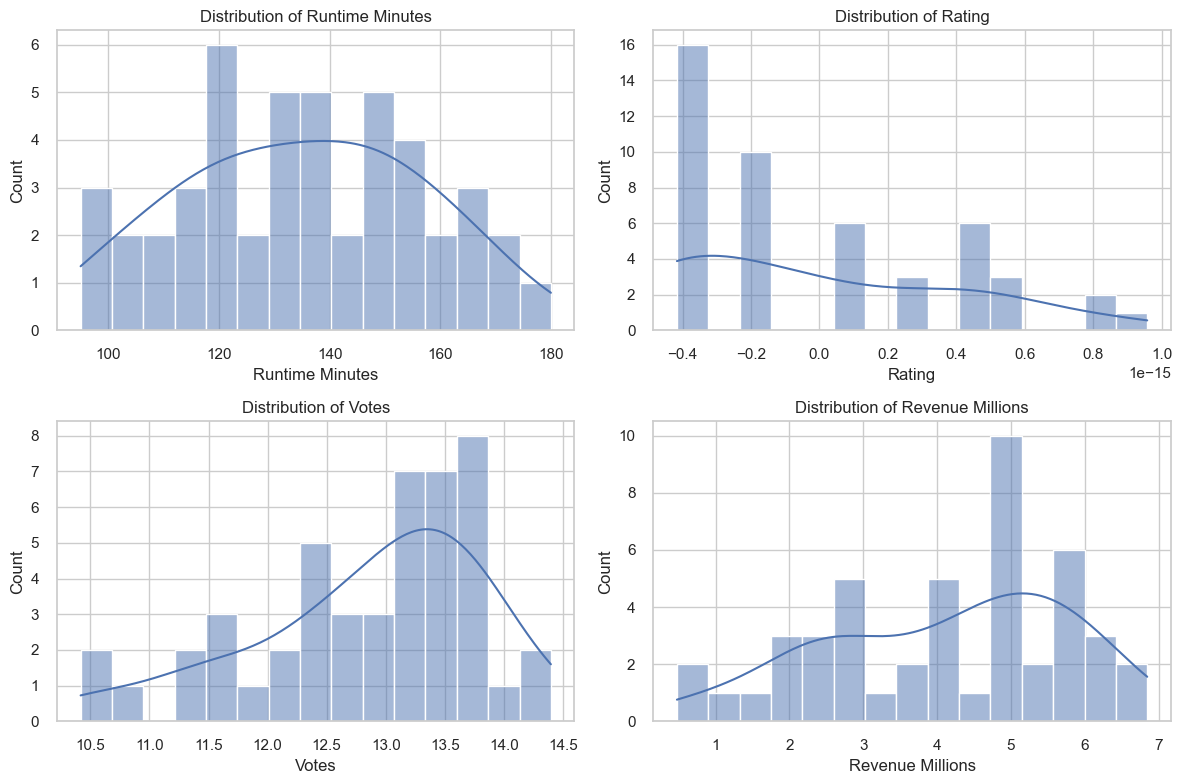

In [10]:
# Plot histograms of all transformed features
plt.figure(figsize=(12, 8))

# Plot each feature
for i, col in enumerate(num_cols):
    plt.subplot(2, 2, i+1)
    sns.histplot(df_transformed[col], kde=True, bins=15)
    plt.title(f'Distribution of {col.replace("..", " ").replace(".", "")}')
    plt.xlabel(col.replace("..", " ").replace(".", ""))
    plt.ylabel('Count')

plt.tight_layout()
plt.savefig('plots/transformed_histograms.png', dpi=300)
plt.show()



In [11]:
# Calculate skewness for all numerical features
for col in num_cols:
    col_skew = df_transformed[col].skew()
    print(f"Skewness of {col.replace('..', ' ').replace('.', '')}: {col_skew:.2f}")


Skewness of Runtime Minutes: -0.01
Skewness of Rating: 0.00
Skewness of Votes: -0.86
Skewness of Revenue Millions: -0.43


# Clustering

In [12]:
# Features to use for PCA
features = ['Runtime..Minutes.', 'Rating', 'Votes', 'Revenue..Millions.']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_transformed[features])


## TREE WITHOUT PCA

In [13]:
# Initialize AgglomerativeClustering (Hierarchical Clustering)
HClust = AgglomerativeClustering

# No n_clusters 
hc = HClust(distance_threshold=0,n_clusters= None, linkage='complete')
hc.fit(X_scaled)

AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        n_clusters=None)

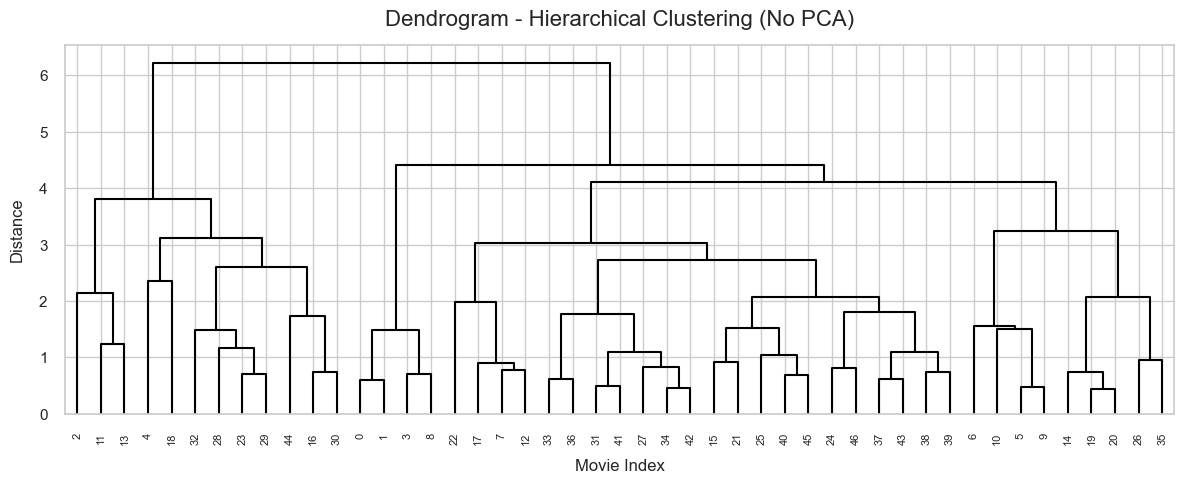

In [14]:
# Create HC without pca, on 4 features
hc_non_pca = HClust(distance_threshold=0,n_clusters= None, linkage='complete')
hc_non_pca.fit(X_scaled)

# Generate linkage matrix
linkage_matrix = compute_linkage(hc_non_pca)

# Plot dendrogram
plt.figure(figsize=(12, 5))
cargs= {'color_threshold':-np.inf,
        'above_threshold_color':'black'}
dendrogram(linkage_matrix, **cargs)
plt.title('Dendrogram - Hierarchical Clustering (No PCA)', y=1.03, fontsize=16)
plt.xlabel('Movie Index', labelpad=10)
plt.ylabel('Distance', labelpad=10)
plt.tight_layout()
plt.savefig('plots/dendrogram_no_pca.png', dpi=300)
plt.show()



## SILHOUETTE HC WITHOUT PCA

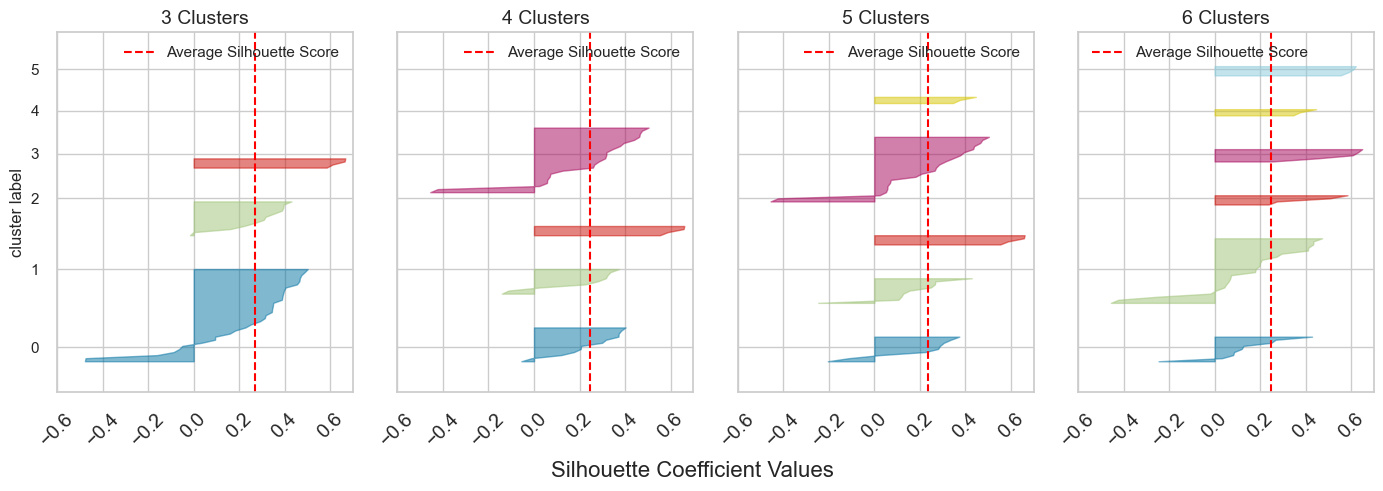

Silhouette Score for 3 clusters: 0.2677
Silhouette Score for 4 clusters: 0.2469
Silhouette Score for 5 clusters: 0.2343
Silhouette Score for 6 clusters: 0.2491


In [15]:
# Custom wrapper class for Yellowbrick to mimic required .predict() method
class AggloModel(BaseEstimator, ClusterMixin):
    def __init__(self, labels, n_clusters):
        self.labels_ = labels
        self.n_clusters = n_clusters

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return self.labels_

fig, axes = plt.subplots(1, 4, figsize=(14, 5), sharex=True, sharey=True)

# Store silhouette scores for each cluster configuration
silhouette_scores = []

for i, n_clusters in enumerate(range(3, 7)):
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete')
    labels = model.fit_predict(X_scaled)

    wrapped_model = AggloModel(labels, n_clusters)
    visualizer = SilhouetteVisualizer(wrapped_model, colors='yellowbrick', ax=axes[i])
    visualizer.fit(X_scaled)
    visualizer.finalize()
    
    # Calculate silhouette score
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

    axes[i].set_title(f"{n_clusters} Clusters", fontsize=14)
    axes[i].tick_params(axis='x', labelrotation=45)
    axes[i].set_xticks([-0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6])
    axes[i].tick_params(axis='x', labelsize=14)  
    
    if i != 0:
        axes[i].set_ylabel("")  # Hide extra y-axis labels
    axes[i].set_xlabel("")      # Hide individual x-axis labels

# Shared x-axis label
fig.text(0.5, 0.03, 'Silhouette Coefficient Values', ha='center', fontsize=16)

# Adjust spacing
plt.tight_layout()
plt.subplots_adjust(wspace=0.15, bottom=0.2)  # LESS wspace for tighter layout
plt.savefig('plots/silhouette_scores_no_pca.png', dpi=300)
plt.show()

# Print silhouette scores for each cluster configuration
for n_clusters, score in zip(range(3, 7), silhouette_scores):
    print(f"Silhouette Score for {n_clusters} clusters: {score:.4f}")


## CLUSTERING HC WITHOUT PCA

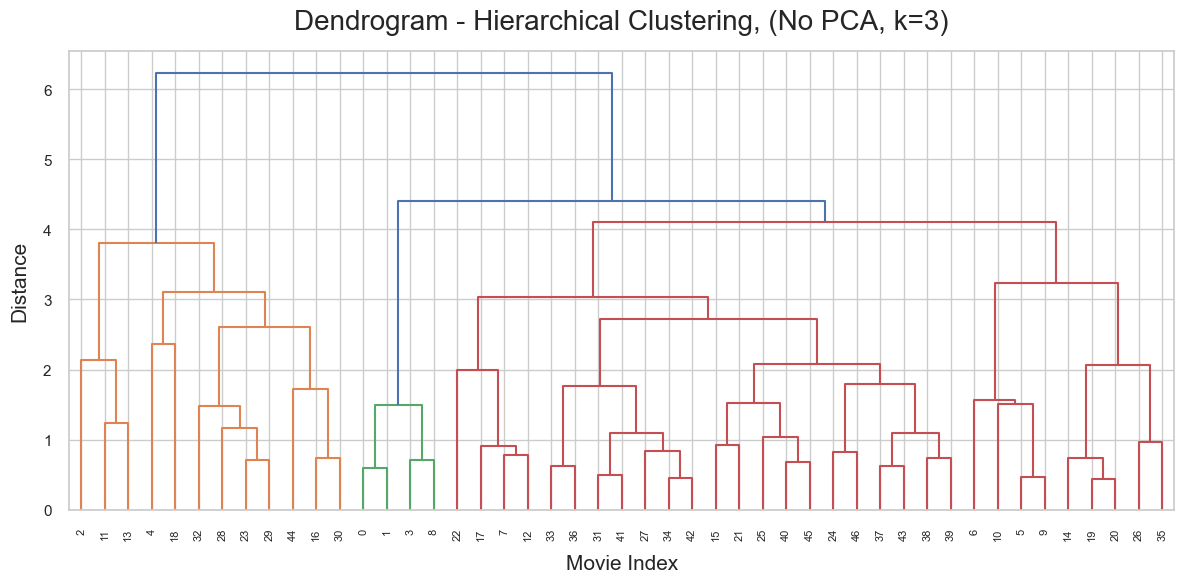

In [16]:
# Instead of using compute_linkage which requires distances_,
# we create the linkage matrix directly from the data
hc_non_pca = AgglomerativeClustering(n_clusters=3, linkage='complete')
hc_non_pca.fit(X_scaled)

# Add cluster labels to the dataframe
df_transformed['Cluster_HC_non_pca'] = hc_non_pca.labels_

# Generate linkage matrix directly from the data
# This avoids the need for the distances_ attribute
linkage_matrix = linkage(X_scaled, method='complete')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix)
plt.title('Dendrogram - Hierarchical Clustering, (No PCA, k=3)', y=1.03, fontsize=20)
plt.xlabel('Movie Index', labelpad=10, fontsize=15)
plt.ylabel('Distance', labelpad=10, fontsize=15)
plt.tight_layout()
plt.savefig('plots/dendrogram_no_pca_clusters.png', dpi=300)
plt.show()


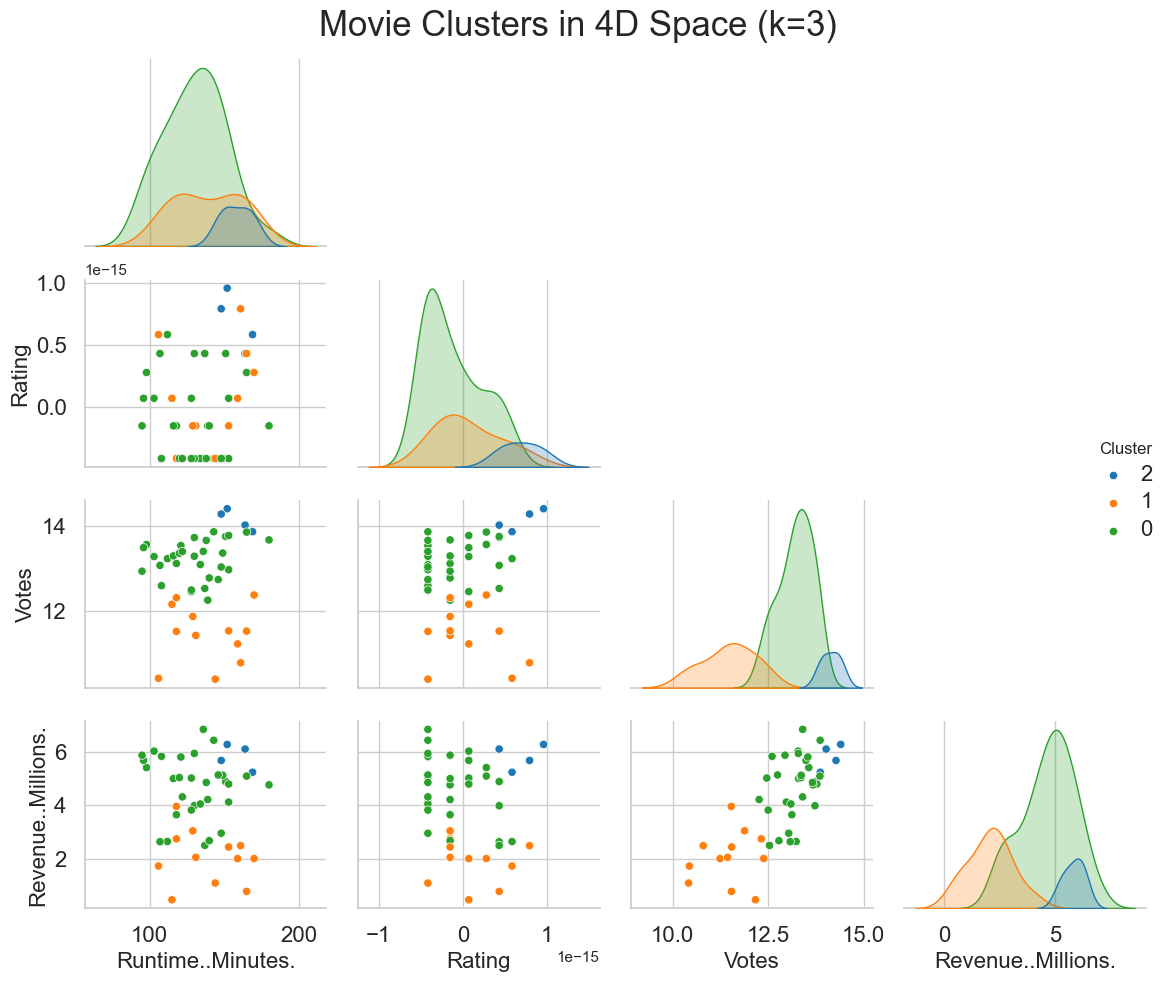

In [17]:
# Add cluster labels to the DataFrame for visualization
df_transformed['Cluster_HC_non_pca'] = df_transformed['Cluster_HC_non_pca'].astype(str)


# Create a pairplot to visualize the clusters in 4D
g = sns.pairplot(df_transformed, hue='Cluster_HC_non_pca', palette='tab10', diag_kind='kde', markers='o', corner=True)
plt.suptitle('Movie Clusters in 4D Space (k=3)', fontsize=25)
# Make axis labels and ticks larger
for ax in g.axes.flat:
    if ax:
        ax.set_xlabel(ax.get_xlabel(), fontsize=16)
        ax.set_ylabel(ax.get_ylabel(), fontsize=16)
        ax.tick_params(axis='both', labelsize=16)
# Resize legend
g._legend.set_title("Cluster")
for text in g._legend.texts:
    text.set_fontsize(16)

plt.tight_layout()
plt.savefig('plots/pairplot_no_pca_clusters.png', dpi=400)
plt.show()

## KMEANS WITHOUT PCA

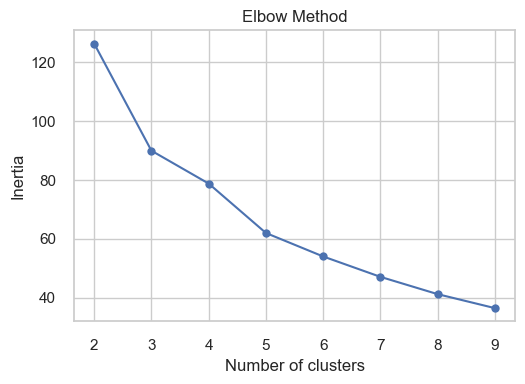

In [18]:
# Elbow method
inertia = []
silhouette_scores = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.tight_layout()
plt.savefig('plots/elbow_kmeans_no_pca.png', dpi=300)


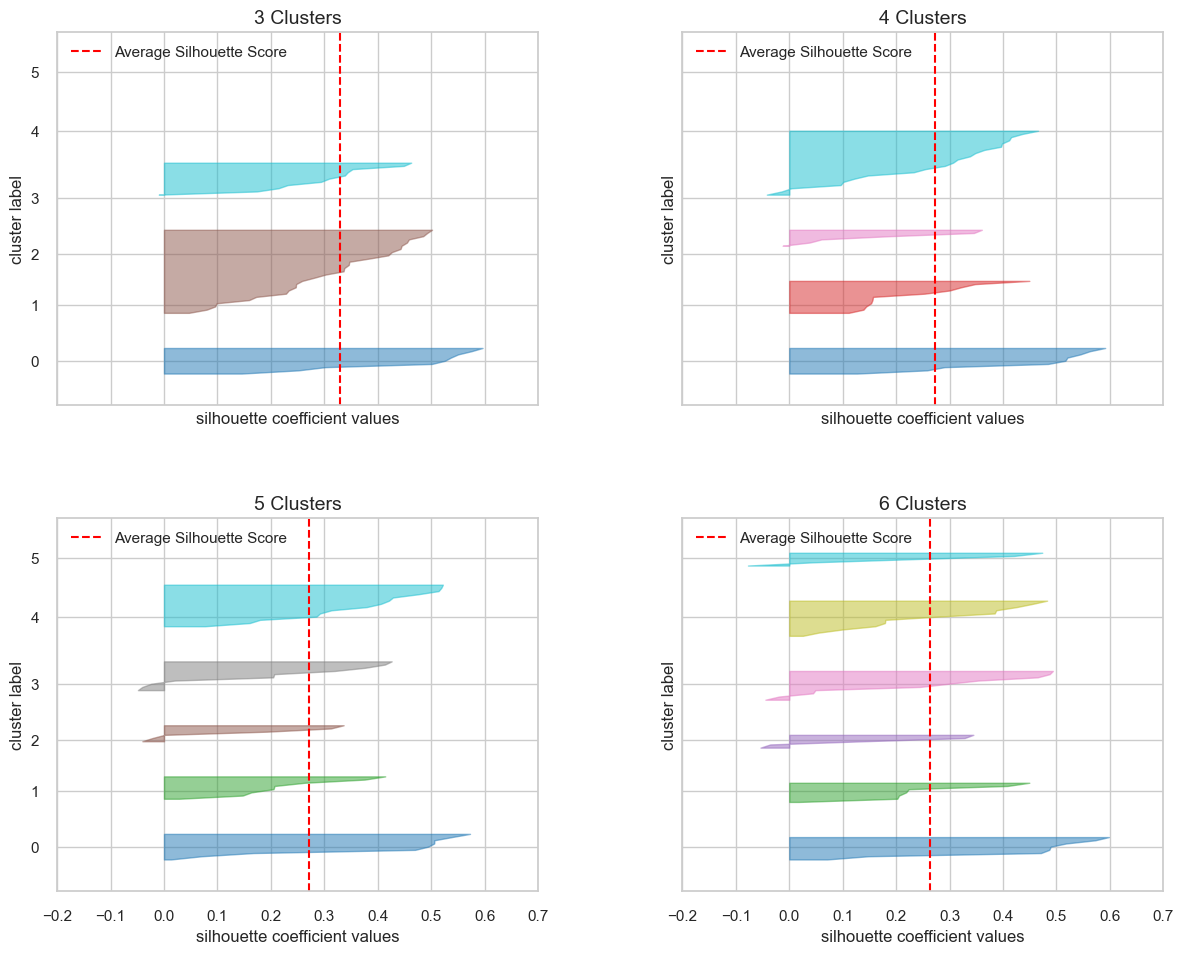

In [19]:
# Silhouette scores and plot for kmeans
fig, ax = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

for i, k in enumerate([3, 4, 5, 6]):
    row, col = i // 2, i % 2
    kmeans = KMeans(n_clusters=k, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors='tab10', ax=ax[row][col])
    visualizer.fit(X_scaled)
    visualizer.finalize()

    # Custom, simple title
    ax[row][col].set_title(f"{k} Clusters", fontsize=14)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.3, bottom=0.1)
plt.savefig('plots/silhouette_kmeans_no_pca.png', dpi=300)
plt.show()


In [20]:
#K-means clustering

# Final K-Means clustering
kmeans_final = KMeans(n_clusters=4, random_state=42)
df_transformed['Cluster_Kmeans_non_pca'] = kmeans_final.fit_predict(X_scaled)

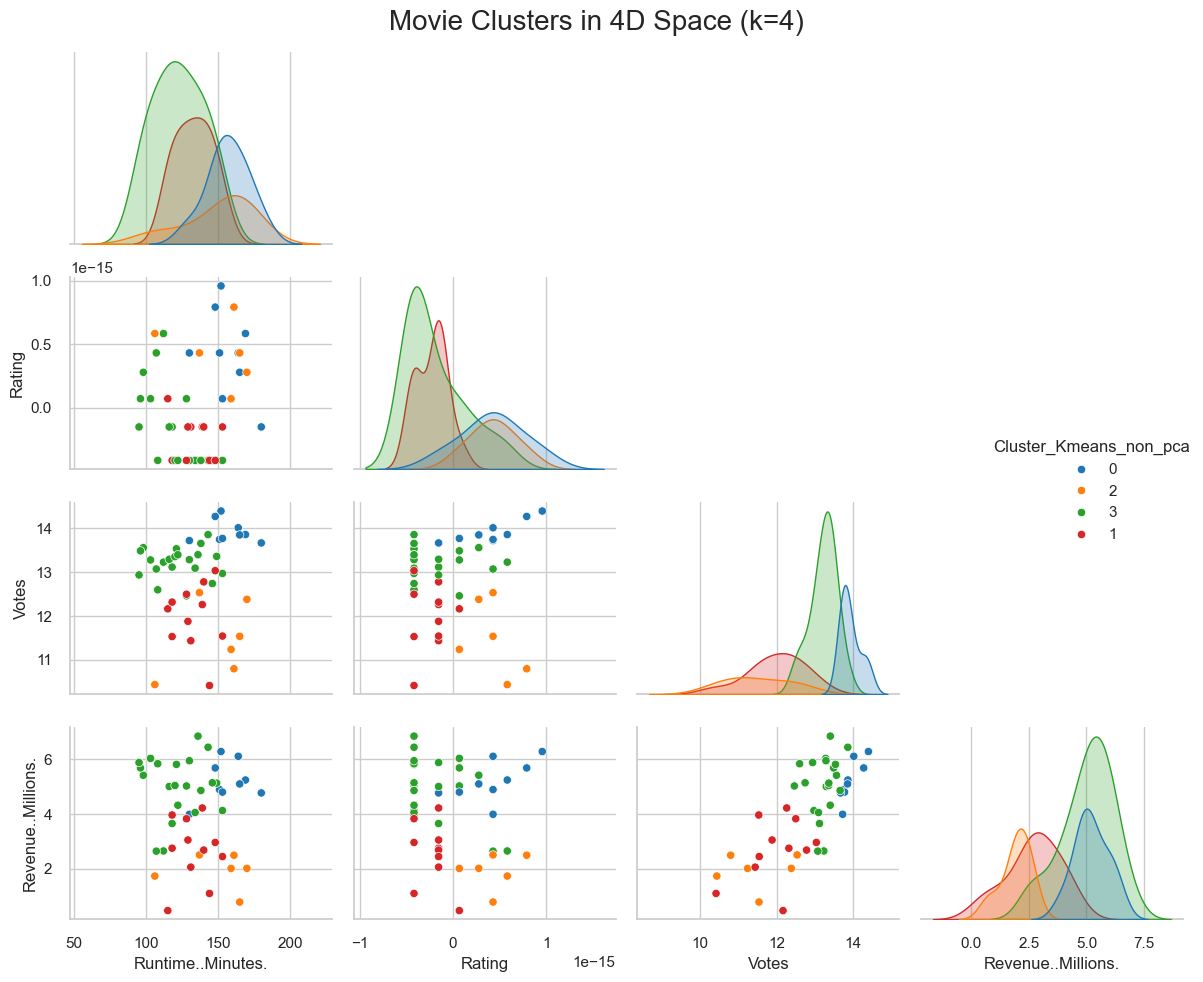

In [21]:
# Add cluster labels to the DataFrame for visualization
df_transformed['Cluster_Kmeans_non_pca'] = df_transformed['Cluster_Kmeans_non_pca'].astype(str)

# Create a pairplot to visualize the clusters in 4D
g = sns.pairplot(df_transformed.drop(['Cluster_HC_non_pca'], axis=1), 
                 hue='Cluster_Kmeans_non_pca', 
                 palette='tab10', 
                 diag_kind='kde', 
                 markers='o',
                 corner=True) 

plt.suptitle('Movie Clusters in 4D Space (k=4)', fontsize=20)
plt.tight_layout()
plt.savefig('plots/pairplot_kmeans_no_pca.png', dpi=400)
plt.show()

### HC offers more distinct, interpretable clusters.  

### Interpretation cluster means

In [22]:
# Get the average values for each cluster

df_summary_hc_no_pca = df_transformed.copy()

# Create a new PowerTransformer with Yeo-Johnson method for Rating only
pt_rating = PowerTransformer(method='yeo-johnson')

# Fit the transformer on the original Rating data
pt_rating.fit(df[['Rating']])

# Get the transformed Rating column as DataFrame to preserve feature names
transformed_rating = df_summary_hc_no_pca[['Rating']]

# Apply inverse transform to get back the original scale for Rating
inverse_transformed_rating = pt_rating.inverse_transform(transformed_rating)

# For Revenue and Votes, apply inverse log1p transformation
df_summary_hc_no_pca['Revenue..Millions.'] = np.exp(df_summary_hc_no_pca['Revenue..Millions.']) - 1
df_summary_hc_no_pca['Votes'] = np.exp(df_summary_hc_no_pca['Votes']) - 1

# Update the Rating with inverse-transformed values
df_summary_hc_no_pca['Rating'] = inverse_transformed_rating

# Verify the inverse transformation by checking summary statistics
print("Summary statistics after inverse transformation:")
print(df_summary_hc_no_pca.groupby('Cluster_HC_non_pca')[['Runtime..Minutes.', 'Rating', 'Votes', 'Revenue..Millions.']].mean().round(2))


Summary statistics after inverse transformation:
                    Runtime..Minutes.  Rating       Votes  Revenue..Millions.
Cluster_HC_non_pca                                                           
0                              130.45    8.23   599185.00              187.69
1                              139.08    8.32   116108.17               11.39
2                              158.25    8.71  1411483.25              365.50


### Interpretation:
- cluster 2: Critically acclaimed blockbusters – longest runtime, highest rating, votes, and revenue. These are likely award-winning epics or franchise hits that succeeded on all fronts. "premium group"
- cluster 1: Mid-performing quality films – longer-than-average, well-rated, but with lower popularity and financial success. Possibly more niche, critically solid but less mainstream. "hidden gems or slow burners"
- cluster 0: Popular, accessible hits – shorter runtime, slightly lower rating, but high votes and strong revenue. These are likely crowd-pleasers, including action or comedy films with wide appeal."mainstream performers"

## PCA for better interpretation

In [23]:
# Apply PCA keeping all components initially
pca = PCA()
X_pca = pca.fit_transform(X_scaled)


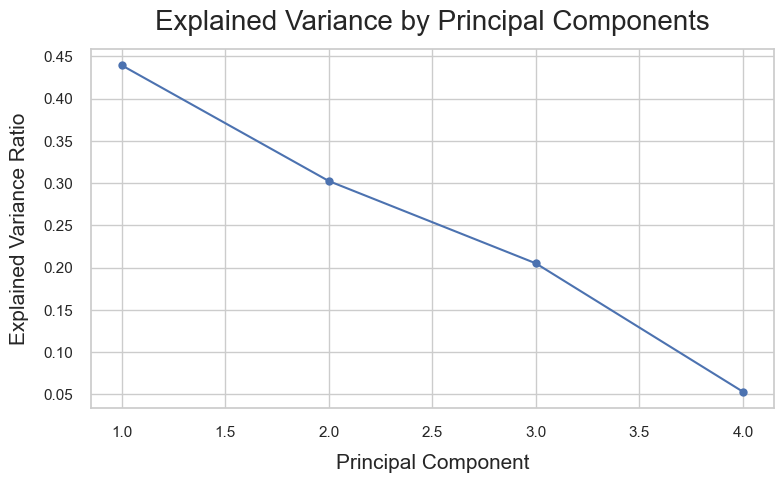

In [24]:
# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
         pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance by Principal Components', y=1.03, fontsize=20)
plt.xlabel('Principal Component', fontsize=15, labelpad=10)
plt.ylabel('Explained Variance Ratio', fontsize=15, labelpad=10)
plt.grid(True)
plt.tight_layout()
plt.savefig('plots/explained_variance_pca.png', dpi=300)
plt.show()


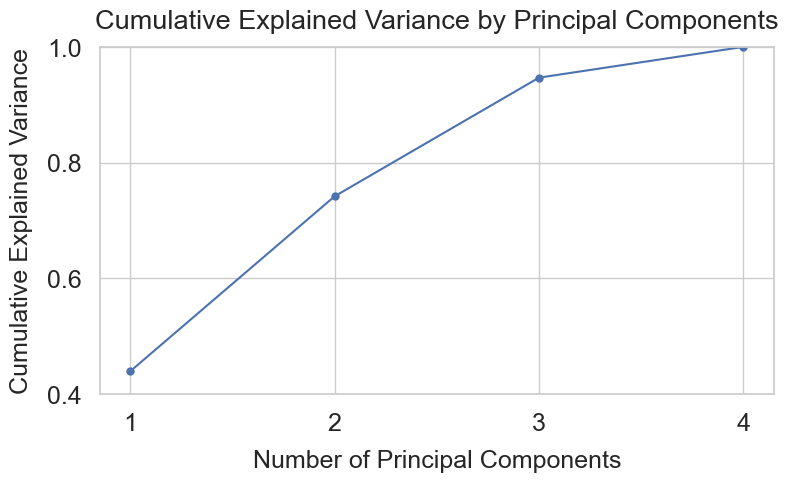

In [25]:
# Plot cumulative explained variance
plt.figure(figsize=(8, 5))

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.plot(range(1, len(cumulative_variance)+1), 
         cumulative_variance, 
         marker='o', 
         linestyle='-')

# Formatting
plt.title('Cumulative Explained Variance by Principal Components', y=1.03, fontsize=19.5)
plt.xlabel('Number of Principal Components', fontsize=18, labelpad=10)
plt.ylabel('Cumulative Explained Variance', labelpad=10, fontsize=18)
plt.grid(True)
plt.xticks(range(1, len(cumulative_variance)+1), fontsize=18)
plt.yticks(np.linspace(0.4, 1, 4), fontsize=18)
plt.ylim(0.4, 1.0)
plt.tight_layout()
plt.savefig('plots/cumulative_explained_variance_pca.png', dpi=300)
plt.show()


In [26]:
# Interpret Components
# PCA components (loadings)
pca_components = pd.DataFrame(
    pca.components_,
    columns=features,
    index=[f'PC{i+1}' for i in range(len(features))]
)

print(pca_components)


     Runtime..Minutes.    Rating     Votes  Revenue..Millions.
PC1          -0.065169 -0.083592  0.693911            0.712217
PC2           0.680324  0.701348  0.205390           -0.055544
PC3           0.724957 -0.686234 -0.048965            0.033499
PC4           0.085723  0.173801 -0.688407            0.698956


PC1: high pc1 means more votes, higher revenue

PC2: high pc2 means longer movies (runtime) and higher rating 

Can confidently use pc1 and pc2 for clustering. plot movies in space for insights and say pc1 is a success/popularity axis while pc2 adds nuance with runtime and revenue mix. 

In [27]:
# Get first two principal components
X_pca_2d = X_pca[:, :2]

## HC with PCA

In [28]:
# No n_clusters
hc_pca = HClust(distance_threshold=0,n_clusters= None, linkage='complete')
hc_pca.fit(X_pca_2d)

AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        n_clusters=None)

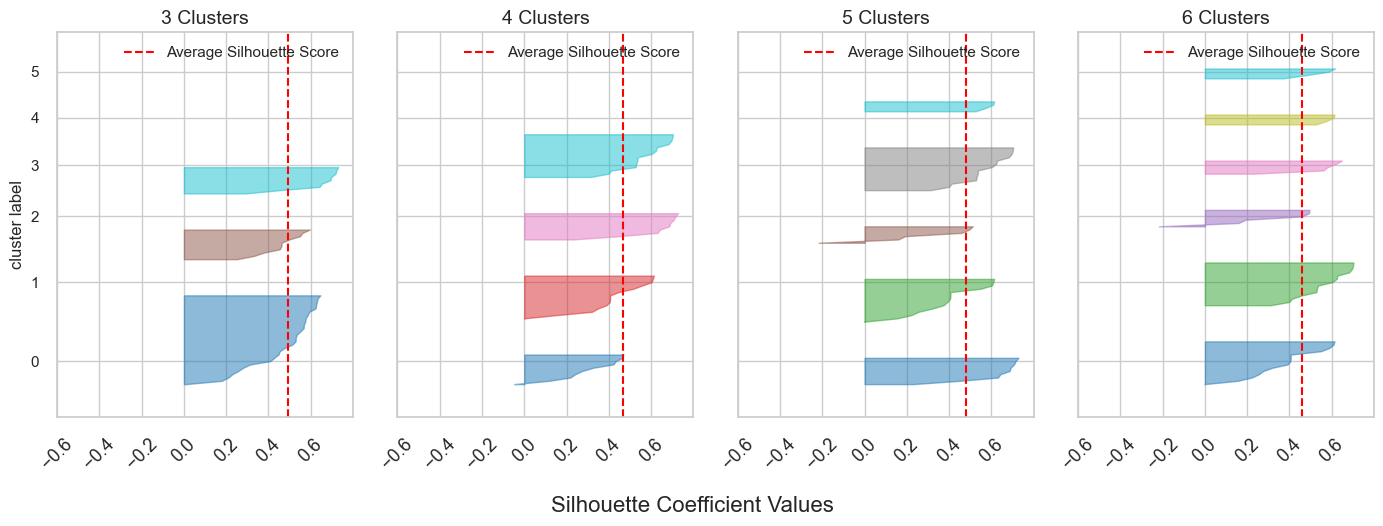

In [29]:
# Explore sihlouettes
# Custom wrapper class for Yellowbrick to mimic required .predict() method
class AggloModel(BaseEstimator, ClusterMixin):
    def __init__(self, labels, n_clusters):
        self.labels_ = labels
        self.n_clusters = n_clusters

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return self.labels_

fig, axes = plt.subplots(1, 4, figsize=(14, 5), sharex=True, sharey=True)

for i, n_clusters in enumerate(range(3, 7)):
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete')
    labels = model.fit_predict(X_pca_2d)

    wrapped_model = AggloModel(labels, n_clusters)
    visualizer = SilhouetteVisualizer(wrapped_model, colors='tab10', ax=axes[i])
    visualizer.fit(X_pca_2d)
    visualizer.finalize()

    axes[i].set_title(f"{n_clusters} Clusters", fontsize=14)

    axes[i].set_xticks([-0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6])
    axes[i].tick_params(axis='x', labelrotation=45, labelsize=13)

    if i != 0:
        axes[i].set_ylabel("")  
    axes[i].set_xlabel("")      

# Add shared x-axis label
fig.text(0.5, -0.04, 'Silhouette Coefficient Values', ha='center', fontsize=16)

# Tighter layout for less wasted space
plt.tight_layout()
plt.subplots_adjust(wspace=0.15, bottom=0.15)
plt.savefig('plots/silhouette_scores_pca.png', dpi=300)
plt.show()



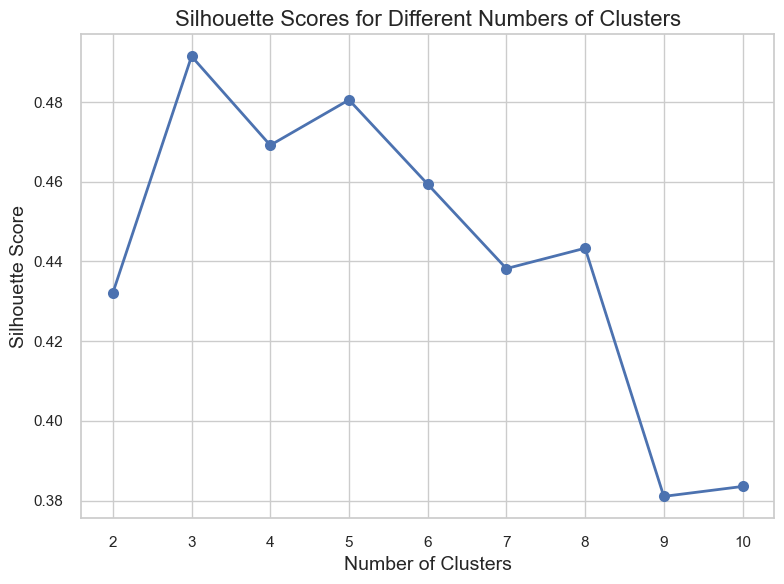

Optimal number of clusters based on silhouette score: 3


In [30]:
# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
cluster_range = range(2, 11)  # Test from 2 to 10 clusters

for n_clusters in cluster_range:
    # Fit Agglomerative Clustering
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete')
    labels = model.fit_predict(X_pca_2d)
    
    # Calculate silhouette score
    score = silhouette_score(X_pca_2d, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, silhouette_scores, 'o-', linewidth=2, markersize=8)
plt.grid(True)
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.title('Silhouette Scores for Different Numbers of Clusters', fontsize=16)
plt.xticks(cluster_range)
plt.tight_layout()
plt.savefig('plots/silhouette_scores_pca_2.png', dpi=300)
plt.show()

# Optimal number of clusters based on silhouette score
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on silhouette score: {optimal_clusters}")


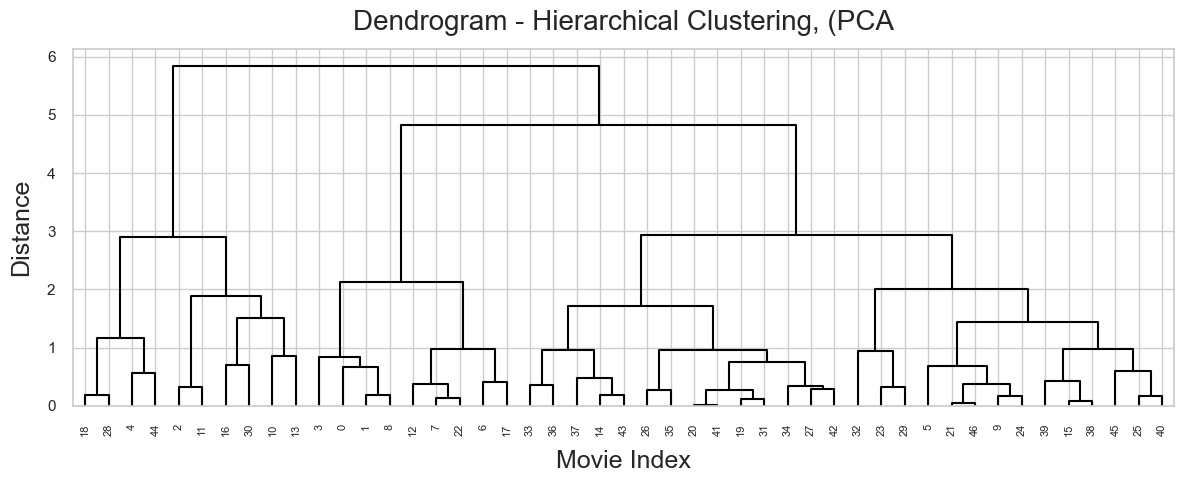

In [31]:
# Dendogram with pca data
hc_pca = HClust(distance_threshold=0,n_clusters= None, linkage='complete')
hc_pca.fit(X_pca_2d)

# Generate linkage matrix
linkage_matrix = compute_linkage(hc_pca)

# Plot dendrogram
plt.figure(figsize=(12, 5))
cargs= {'color_threshold':-np.inf,
        'above_threshold_color':'black'}
dendrogram(linkage_matrix, **cargs)
plt.title('Dendrogram - Hierarchical Clustering, (PCA', y=1.03, fontsize=20)
plt.xlabel('Movie Index', fontsize=18, labelpad=10)
plt.ylabel('Distance', fontsize=18, labelpad=10)
plt.tight_layout()
plt.savefig('plots/dendrogram_pca.png', dpi=300)
plt.show()



In [32]:
# 3 Clusters
hc_pca = HClust(n_clusters= 3, linkage='complete')
hc_pca.fit(X_pca_2d)

AgglomerativeClustering(linkage='complete', n_clusters=3)

In [33]:
# Add cluster labels to the dataframe
df_transformed['Cluster_HC_pca'] = hc_pca.labels_

# Generate linkage matrix
linkage_matrix = linkage(X_pca_2d, method='complete')

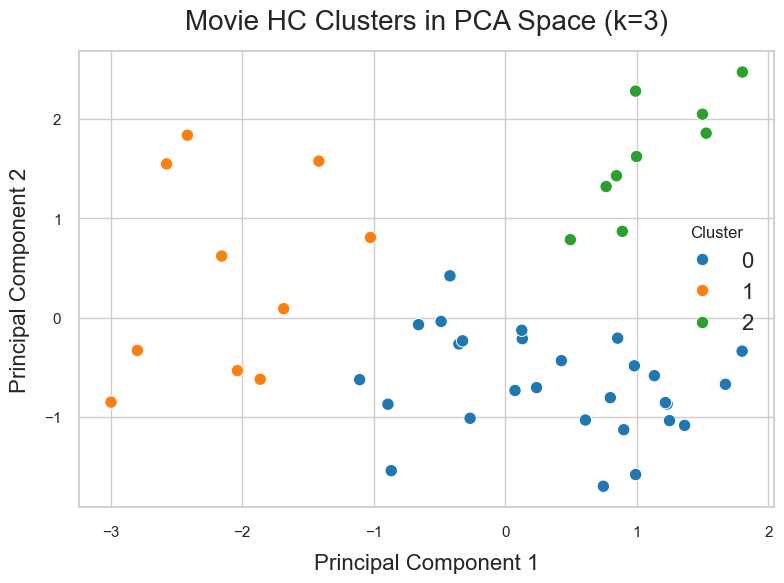

In [34]:
# Plot clusters in PCA 2D space
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca_2d[:, 0], y=X_pca_2d[:, 1],
                hue=df_transformed['Cluster_HC_pca'], palette='tab10', s=80)
plt.title('Movie HC Clusters in PCA Space (k=3)', fontsize=20, y=1.03)
plt.xlabel('Principal Component 1', fontsize=16, labelpad=10)
plt.ylabel('Principal Component 2', fontsize=16, labelpad=10)
plt.legend(title='Cluster', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig('plots/pca_clusters.png', dpi=300)
plt.show()

In [35]:
# Get movie titles for each cluster
cluster_titles = {}

# Loop through each unique cluster
for cluster in sorted(df_transformed['Cluster_HC_pca'].unique()):
    # Get the indices of movies in this cluster
    indices_in_cluster = df_transformed[df_transformed['Cluster_HC_pca'] == cluster].index.tolist()
    
    # Get the corresponding titles from the original dataframe
    # (since df_transformed doesn't contain the Title column)
    titles_in_cluster = df.loc[indices_in_cluster, 'Title'].tolist()
    
    # Store in dictionary
    cluster_titles[f"Cluster {cluster}"] = titles_in_cluster
    
    # Print the cluster and number of movies
    print(f"Cluster {cluster}: {len(titles_in_cluster)} movies")
    
    # Print the first 5 titles (or fewer if cluster has less than 5 movies)
    print("Sample titles:")
    for title in titles_in_cluster:
        print(f"  - {title}")
    print()


Cluster 0: 28 movies
Sample titles:
  - The Intouchables
  - Whiplash
  - WALL·E
  - Koe no katachi
  - Jagten
  - Paint It Black
  - Up
  - Hacksaw Ridge
  - The Wolf of Wall Street
  - Room
  - Warrior
  - Pan's Labyrinth
  - Gran Torino
  - El secreto de sus ojos
  - PK
  - Guardians of the Galaxy
  - Lion
  - Star Wars: Episode VII - The Force Awakens
  - Mad Max: Fury Road
  - Zootopia
  - The Avengers
  - Gone Girl
  - Prisoners
  - The Help
  - 12 Years a Slave
  - Harry Potter and the Deathly Hallows: Part 2
  - Shutter Island
  - Ah-ga-ssi

Cluster 1: 10 movies
Sample titles:
  - Dangal
  - Kimi no na wa
  - The Lives of Others
  - Taare Zameen Par
  - 3 Idiots
  - La La Land
  - Inglourious Basterds
  - Inside Out
  - Incendies
  - No Country for Old Men

Cluster 2: 9 movies
Sample titles:
  - The Dark Knight
  - Inception
  - Interstellar
  - The Prestige
  - The Departed
  - The Dark Knight Rises
  - Django Unchained
  - Bahubali: The Beginning
  - Toy Story 3



### INTERPRETATION
- Cluster 2 (Green): Located in the upper-right quadrant of the PCA space. Clearly distinct from the rest — farthest along both PC1 and PC2. Matches Cluster 0 from the table:High rating, longest runtime, highest revenue and votes. Interpretation: Premium blockbusters or epics.

- Cluster 1 (Orange): Spread across the left side of the PCA plot, mostly along negative PC1. Shows more variation on PC2, suggesting more internal diversity. Matches your Cluster 1 from the table:Mid-tier films with longer runtimes but lower revenue and votes.Interpretation: Niche, less popular content — potentially critical favorites with limited reach.

- Cluster 0 (Blue):Concentrated in the lower-right quadrant, mostly around PC1 = 0 to 1, and PC2 < 0. Compact and well-separated — suggests good internal consistency. Matches your Cluster 2 from the table: Shorter runtime, high votes, high revenue. Interpretation: Popular, accessible hits.


### Why PCA Is a Good Decision in This Project:
- High Variance Retention: The first two principal components (PC1 and PC2) together explain more than 70% of the total variance in the dataset. This means PCA preserves most of the original information, making the 2D projection highly representative of the full feature space. Its informative and reliable

- Interpretable Loadings: PC1 (votes and revenue) and PC2 (runtime and rating). This makes the PCA plot intuitive for interpreting how clusters are positioned in terms of actual movie traits.

- Effective Cluster Separation in PCA scatterplots, clusters are visually distinct — which supports that the clustering worked well. It allows us to spot outliers and understand cluster shapes (e.g., compact vs dispersed)

- Better Than Pairplots (for summary view): While pairplots are excellent for pairwise relationships, PCA gives you a compressed global overview — a bird’s-eye view of the entire clustering result in one clean plot.

